# State tomography

In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
import time
import warnings
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import quantpy as qp

from tqdm import tqdm_notebook as tqdm

titlesize = 24
labelsize = 22
legendsize = 18
xticksize = 18
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

warnings.filterwarnings('ignore', category=np.ComplexWarning)

%matplotlib inline

## Quality of point estimates

In [40]:
def test_quality(rho, title):
    n_repeats = 50
    n_points = 30

    tmg = qp.StateTomograph(rho)

    dist_lin = np.zeros((n_points, n_repeats))
    dist_mle_lin_init = np.zeros((n_points, n_repeats))
    dist_mle_mixed_init = np.zeros((n_points, n_repeats))
    dist_mle_constr_lin_init = np.zeros((n_points, n_repeats))
    dist_mle_constr_mixed_init = np.zeros((n_points, n_repeats))

    for i, n_measurements in enumerate(np.logspace(1, 8, num=n_points, dtype=int)):
        for j in range(n_repeats):
            tmg.experiment(n_measurements)
            dist_lin[i, j] = qp.hs_dst(rho, tmg.point_estimate('lin'))
            dist_mle_lin_init[i, j] = qp.hs_dst(rho, tmg.point_estimate('mle', init='lin'))
            dist_mle_mixed_init[i, j] = qp.hs_dst(rho, tmg.point_estimate('mle', init='mixed'))
            dist_mle_constr_lin_init[i, j] = qp.hs_dst(rho, tmg.point_estimate('mle-constr', init='lin'))
            dist_mle_constr_mixed_init[i, j] = qp.hs_dst(rho, tmg.point_estimate('mle-constr', init='mixed'))
    
    plt.figure(figsize=(15, 13), dpi=200)
    plt.grid()
    plt.xlabel('Number of measurements')
    plt.ylabel('HS distance')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title)
    plt.plot(np.logspace(1, 8, num=n_points, dtype=int), 
             dist_lin.mean(axis=1), '--', label='Linear inversion')
    plt.plot(np.logspace(1, 8, num=n_points, dtype=int), 
             dist_mle_mixed_init.mean(axis=1), '--', label='MLE with fully mixed initial guess')
    plt.plot(np.logspace(1, 8, num=n_points, dtype=int), 
             dist_mle_lin_init.mean(axis=1), '--', label='MLE with LI as initial guess')
    plt.plot(np.logspace(1, 8, num=n_points, dtype=int), 
             dist_mle_constr_mixed_init.mean(axis=1), '--', label='Constrained MLE with fully mixed initial guess')
    plt.plot(np.logspace(1, 8, num=n_points, dtype=int), 
             dist_mle_constr_lin_init.mean(axis=1), '--', label='Constrained MLE with LI as initial guess')
    plt.legend()
    fname = title.lower().replace(' ', '_')
    plt.savefig('pictures/qst_{}.png'.format(fname), dpi=200)

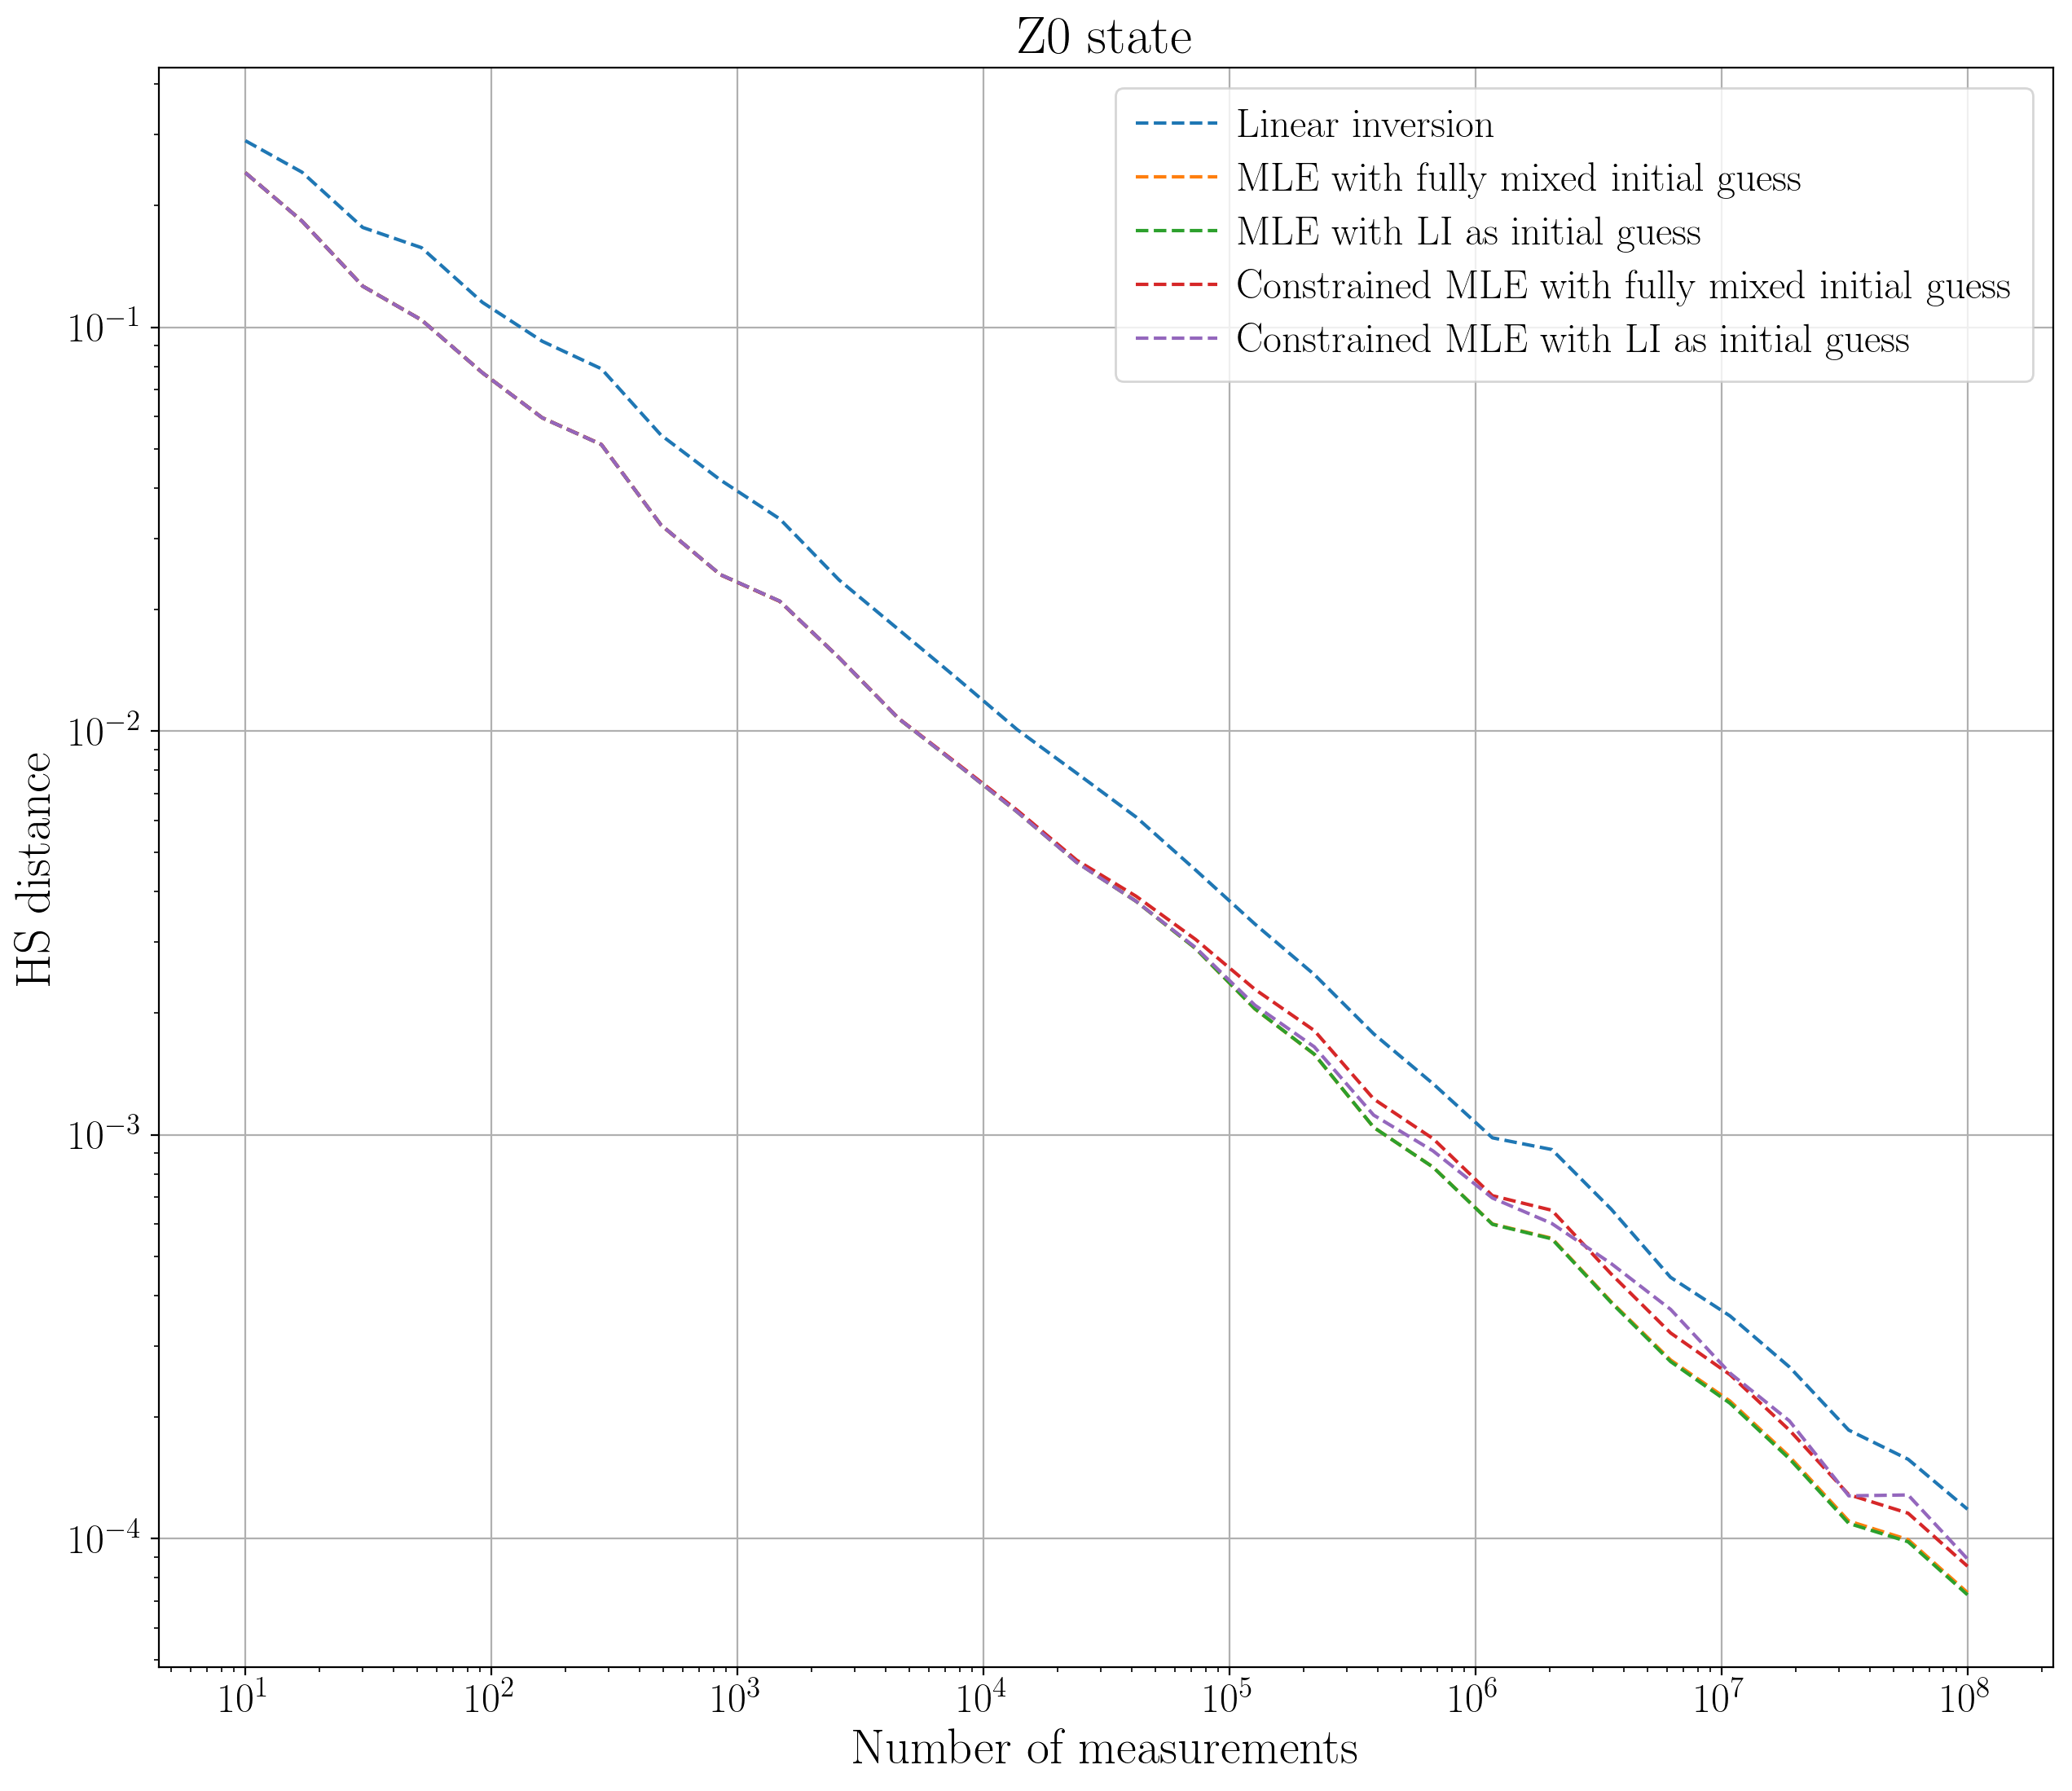

In [41]:
rho = qp.Qobj([0.5, 0, 0, 0.5])
test_quality(rho, 'Z0 state')

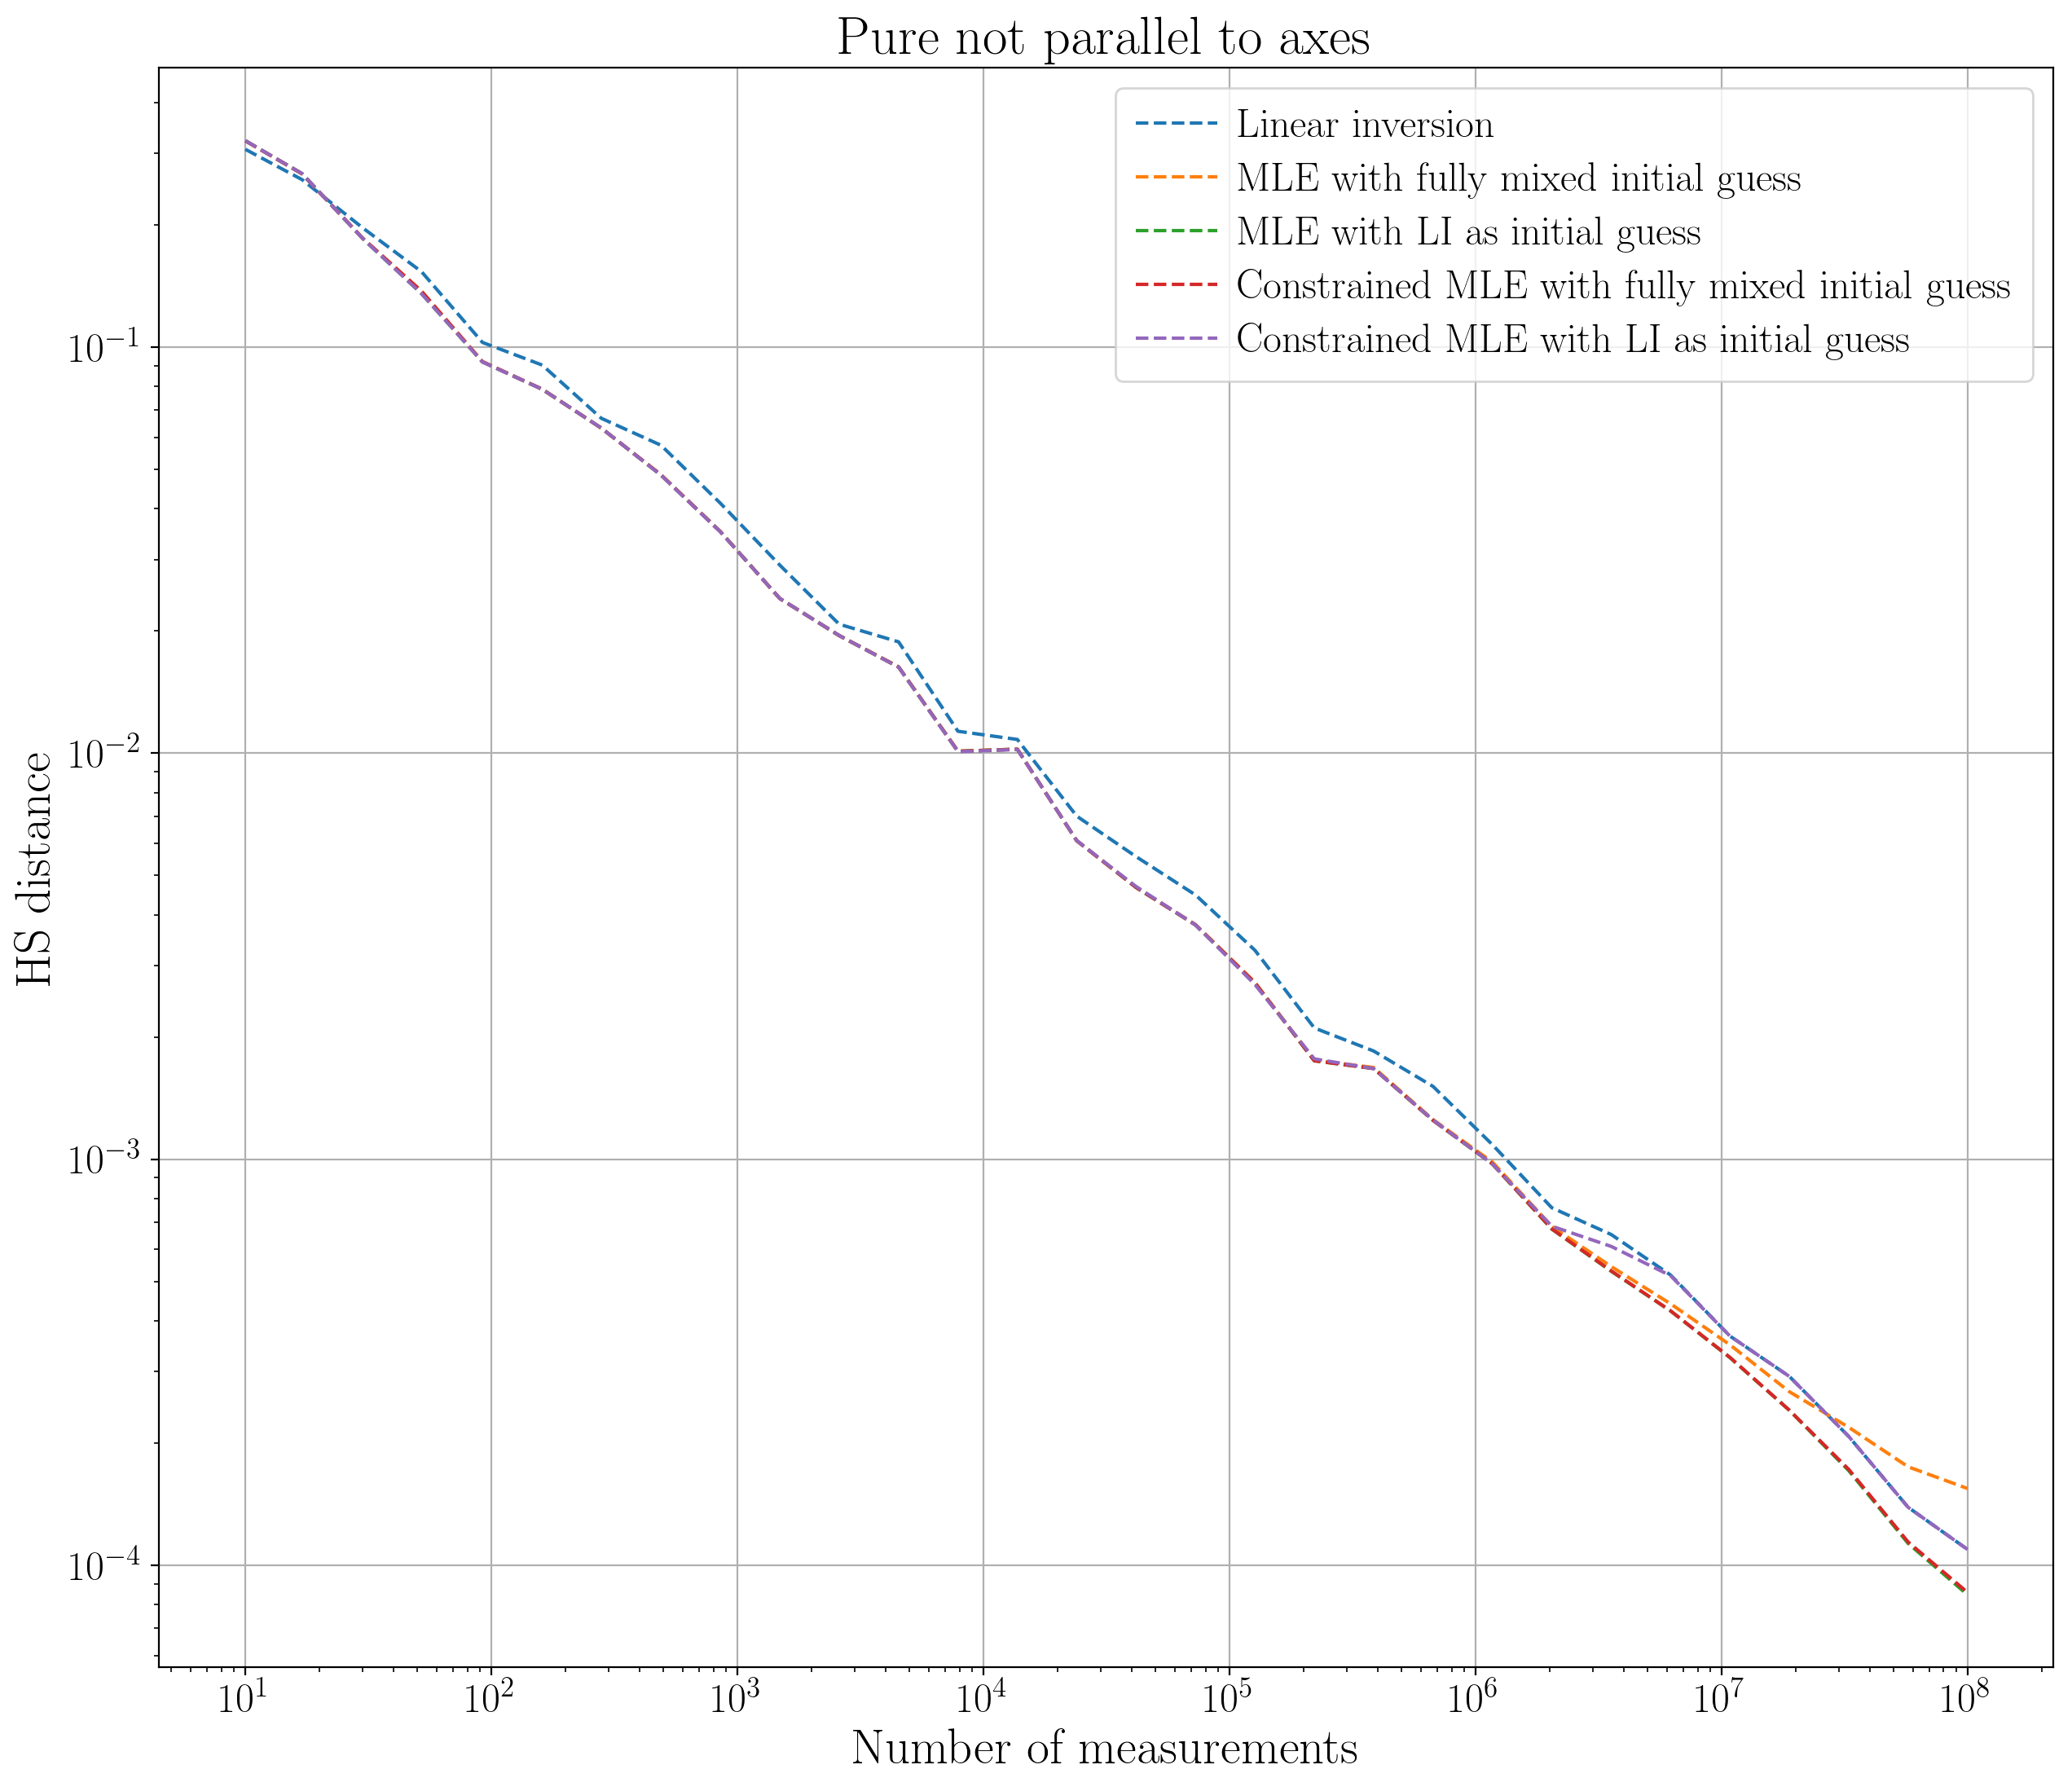

In [42]:
rho = qp.Qobj([0.5, np.sqrt(1/12), np.sqrt(1/12), np.sqrt(1/12)])
test_quality(rho, 'Pure not parallel to axes')

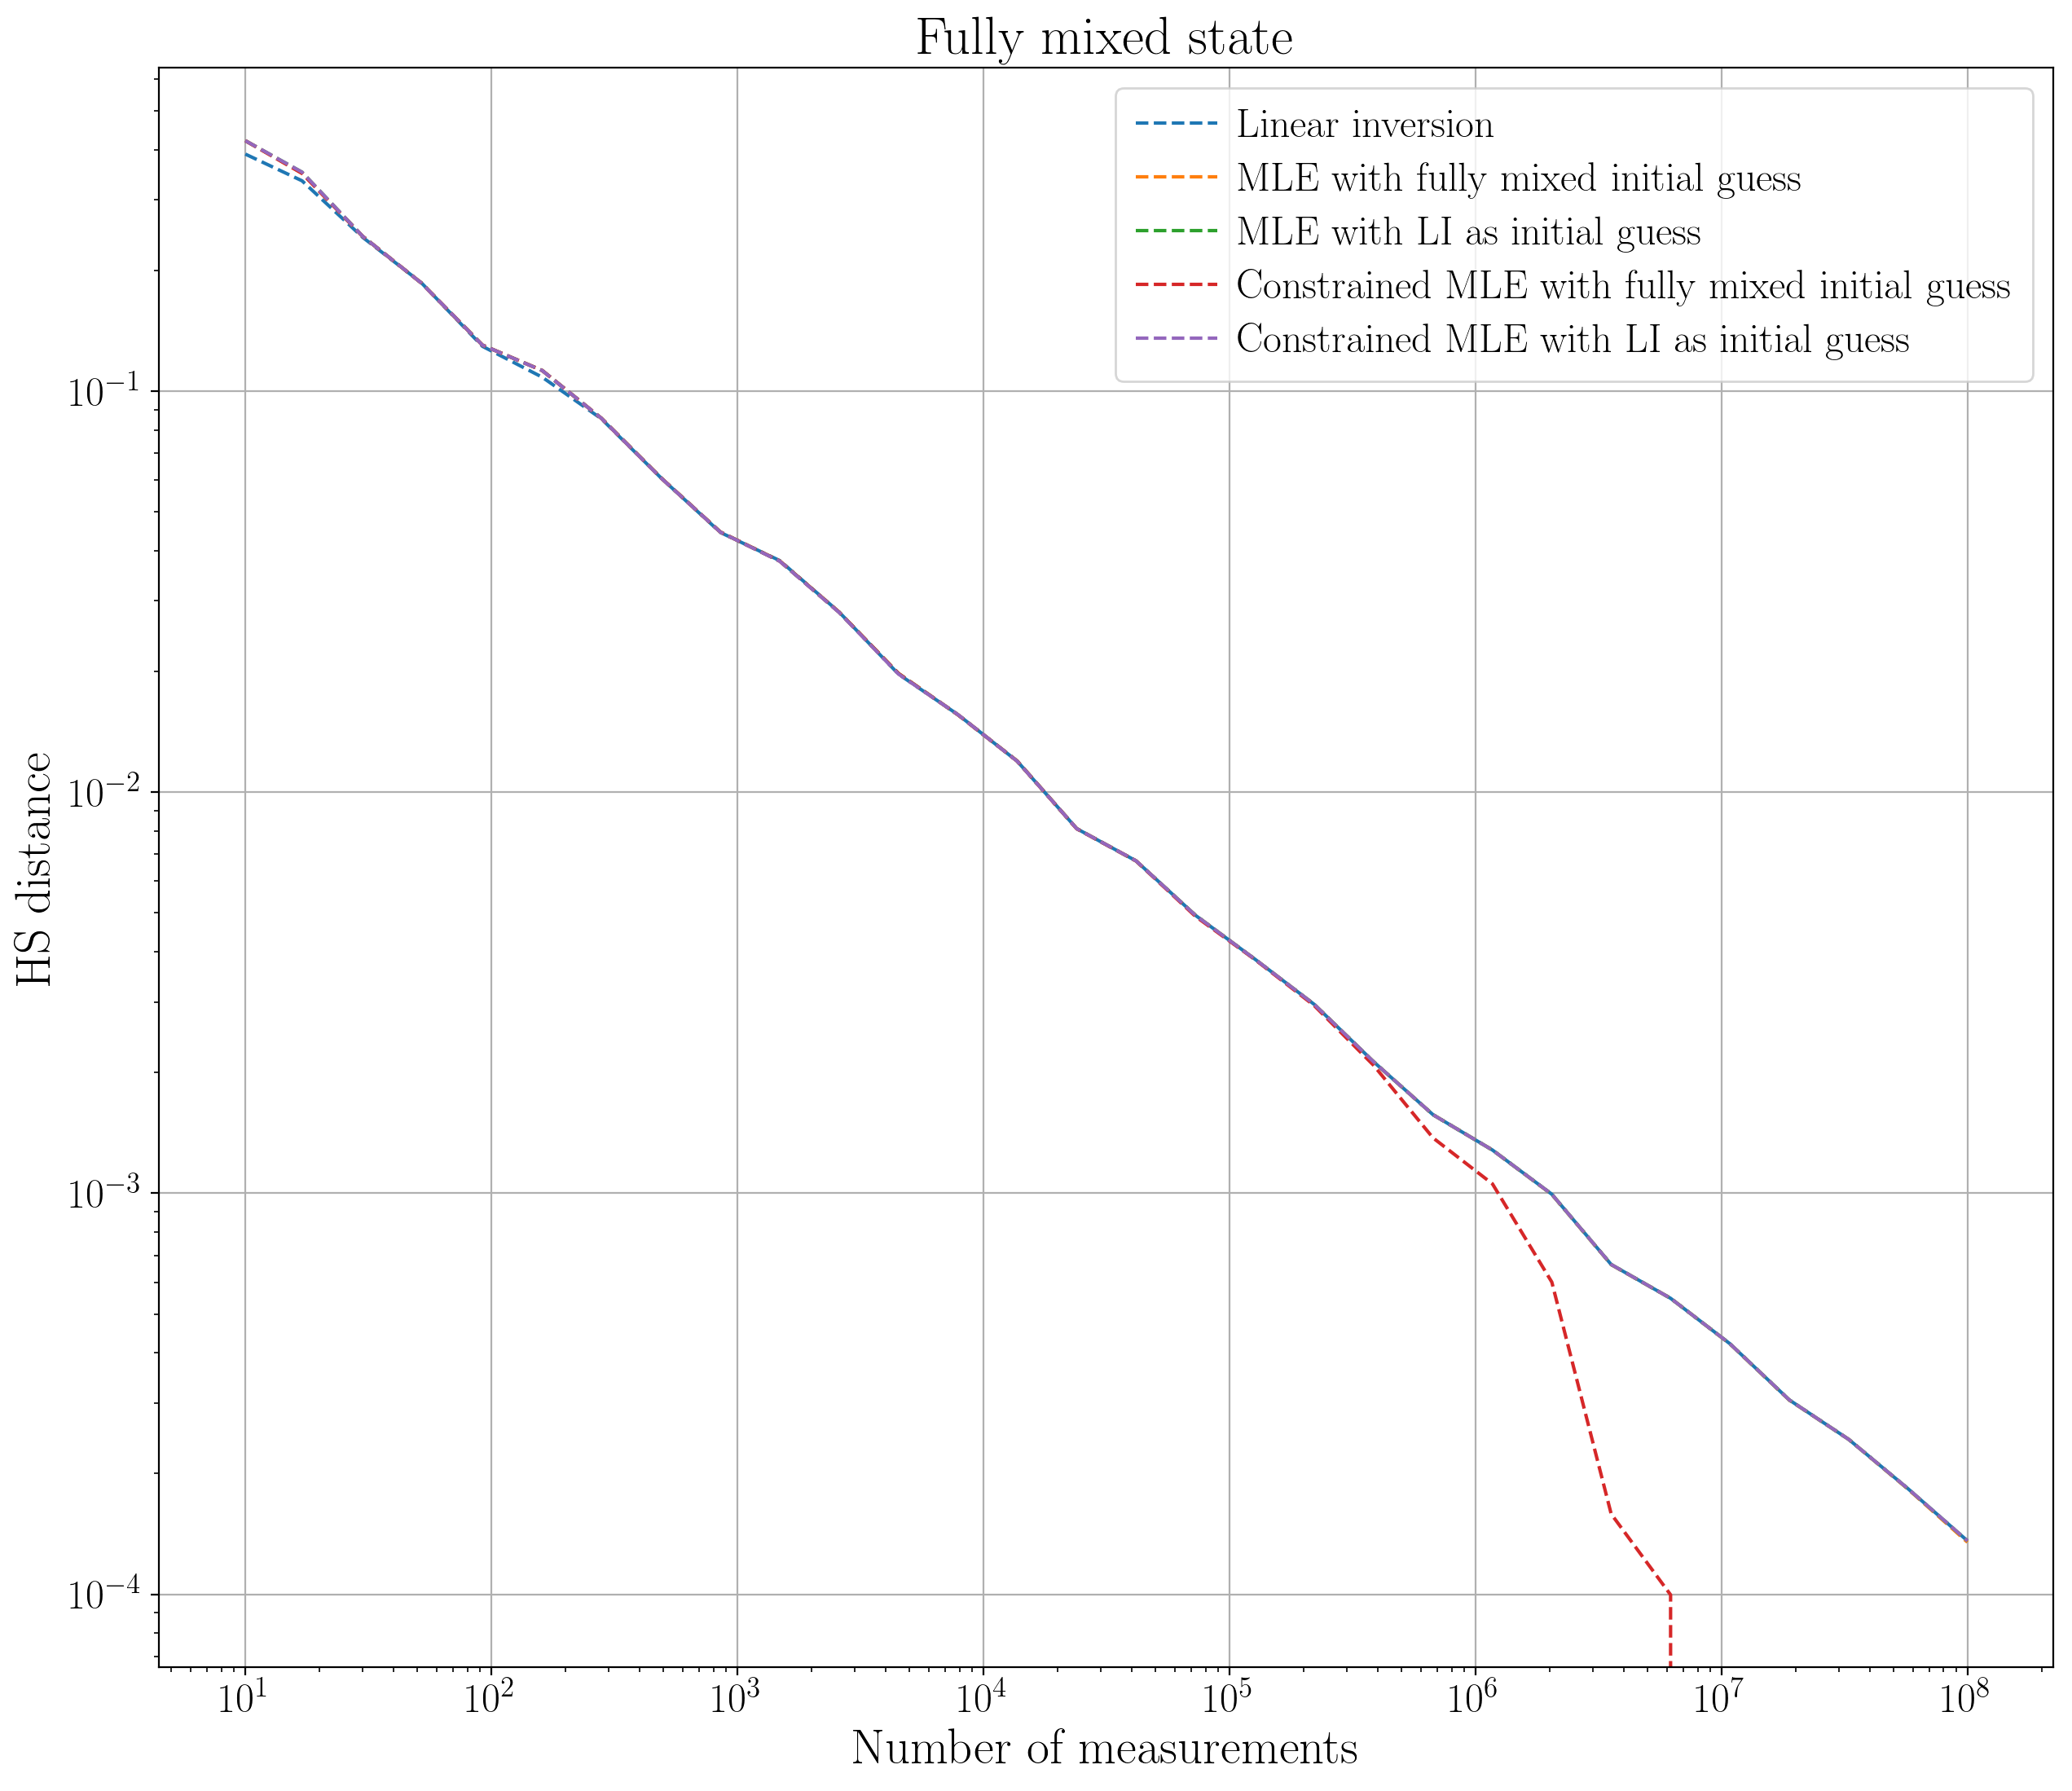

In [43]:
rho = qp.Qobj([0.5, 0, 0, 0])
test_quality(rho, 'Fully mixed state')

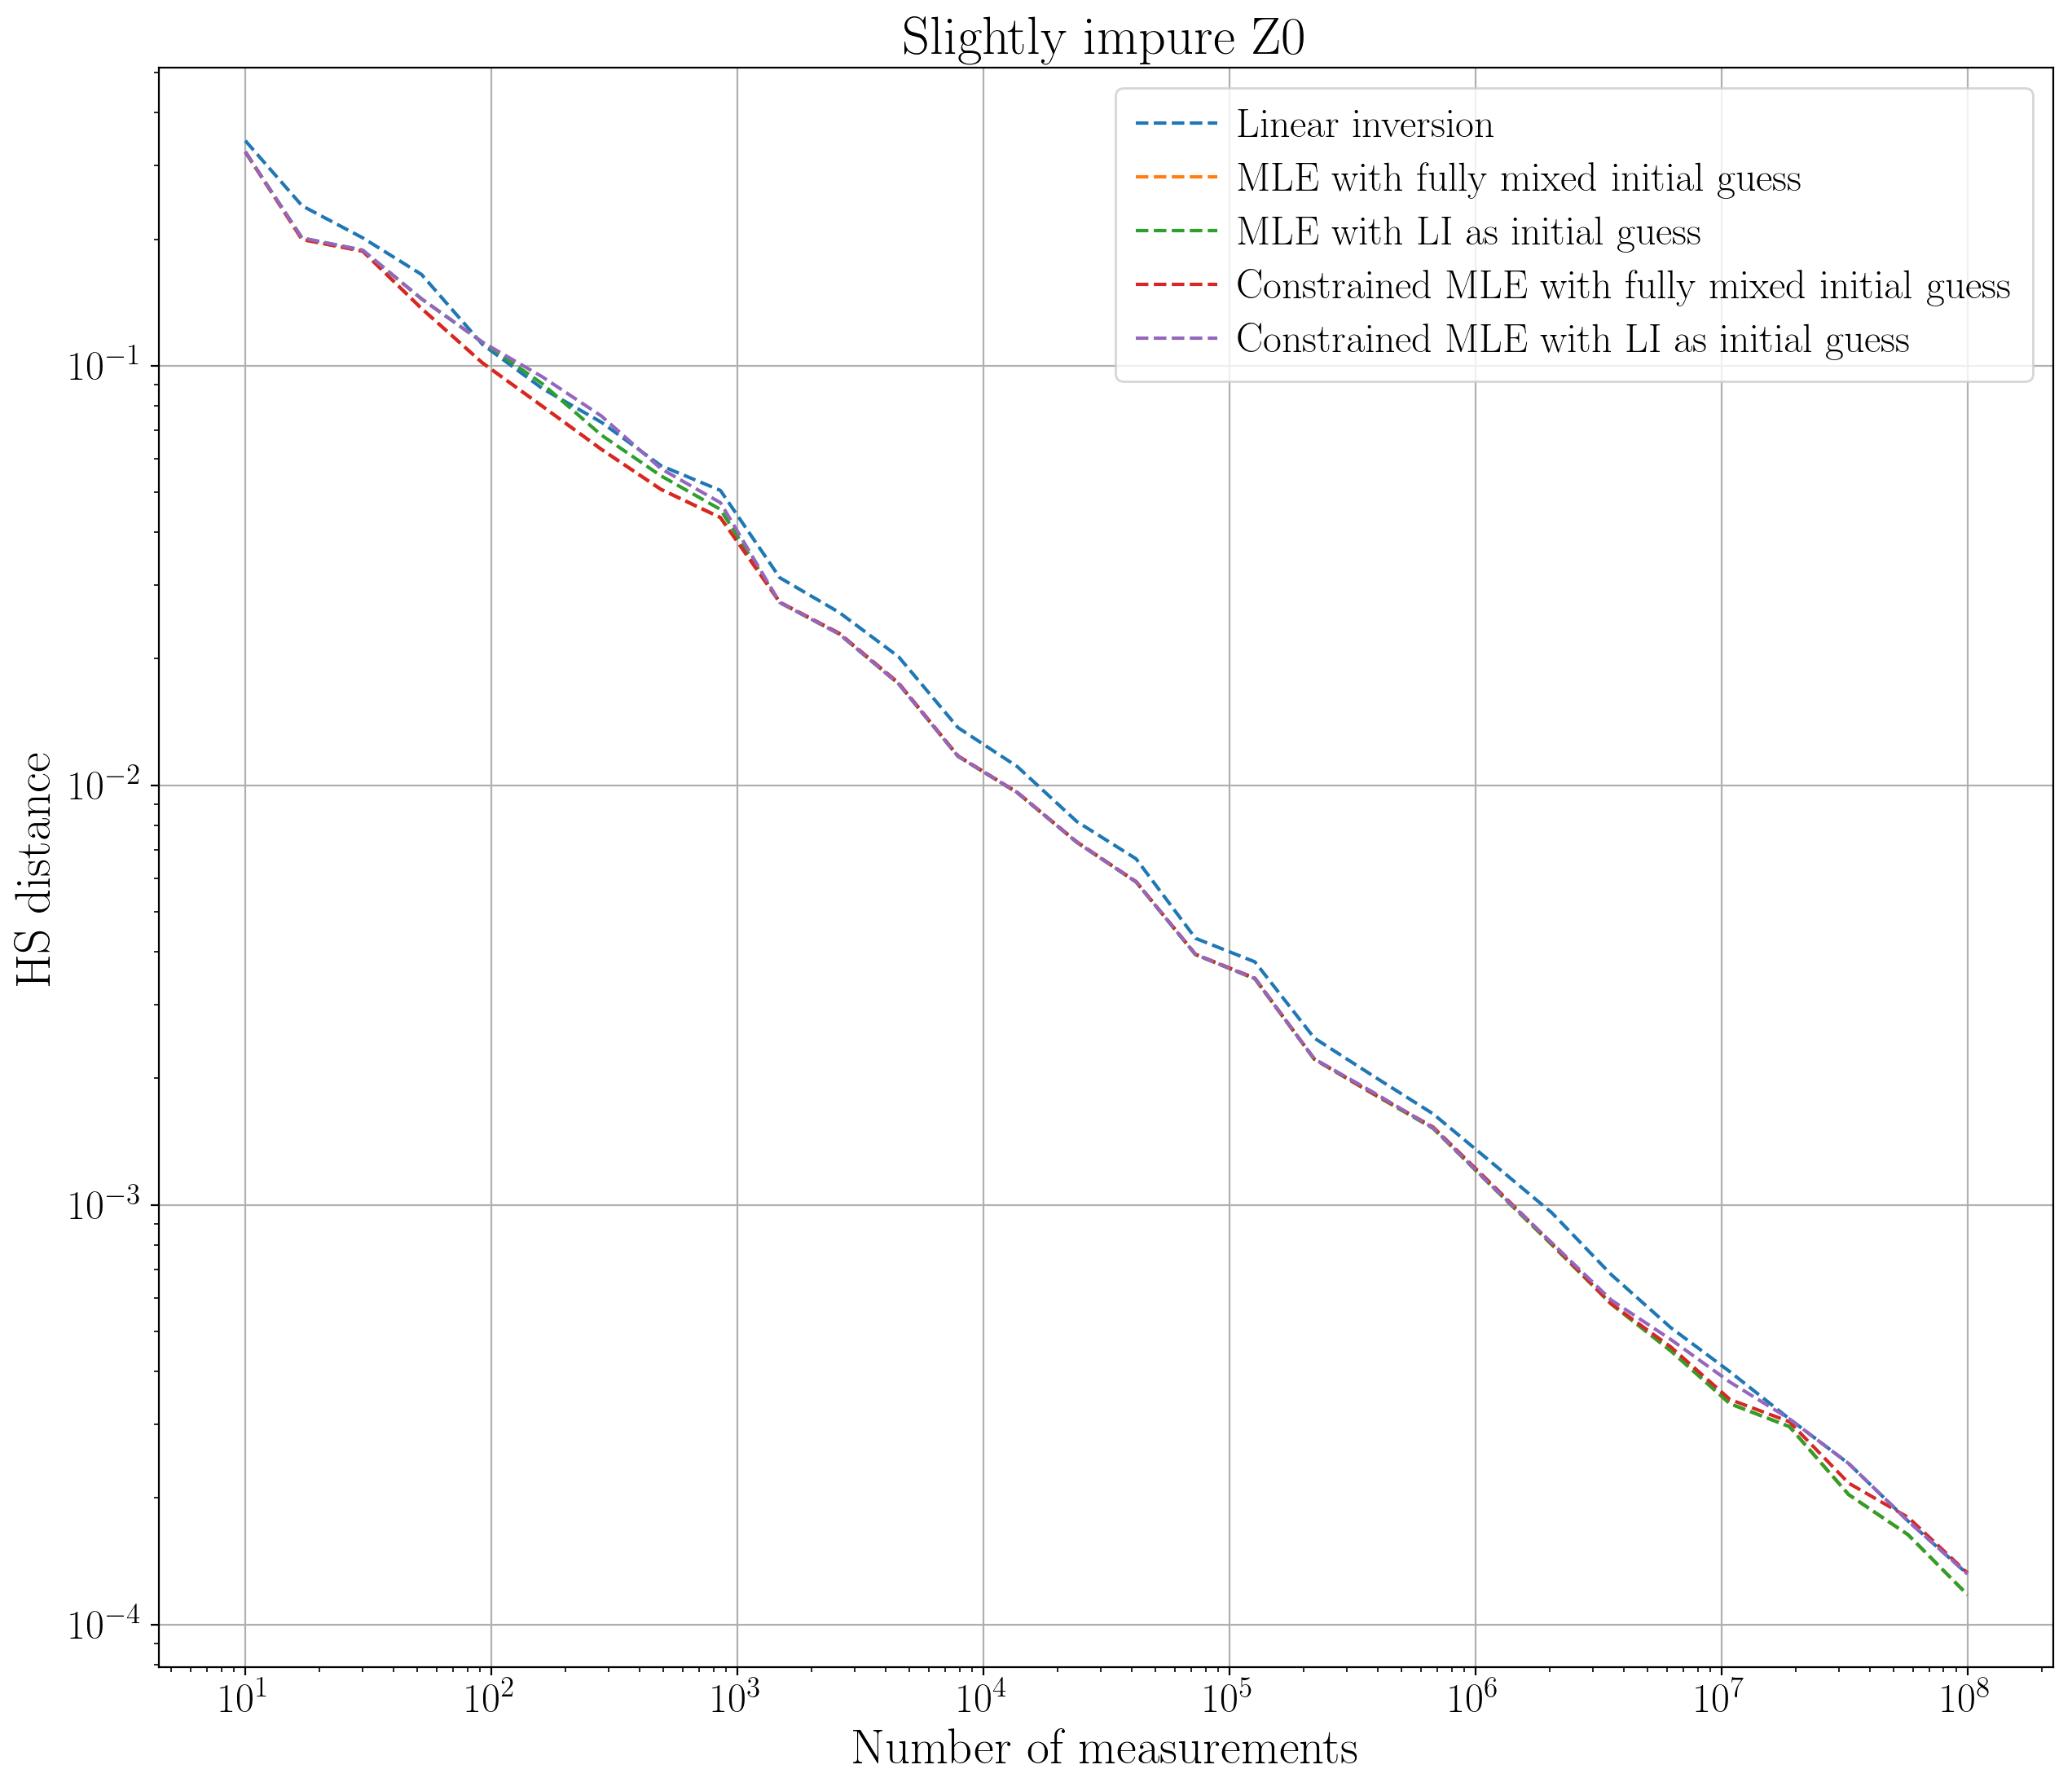

In [44]:
rho = qp.Qobj([0.5, 0, 0, 0.45])
test_quality(rho, 'Slightly impure Z0')

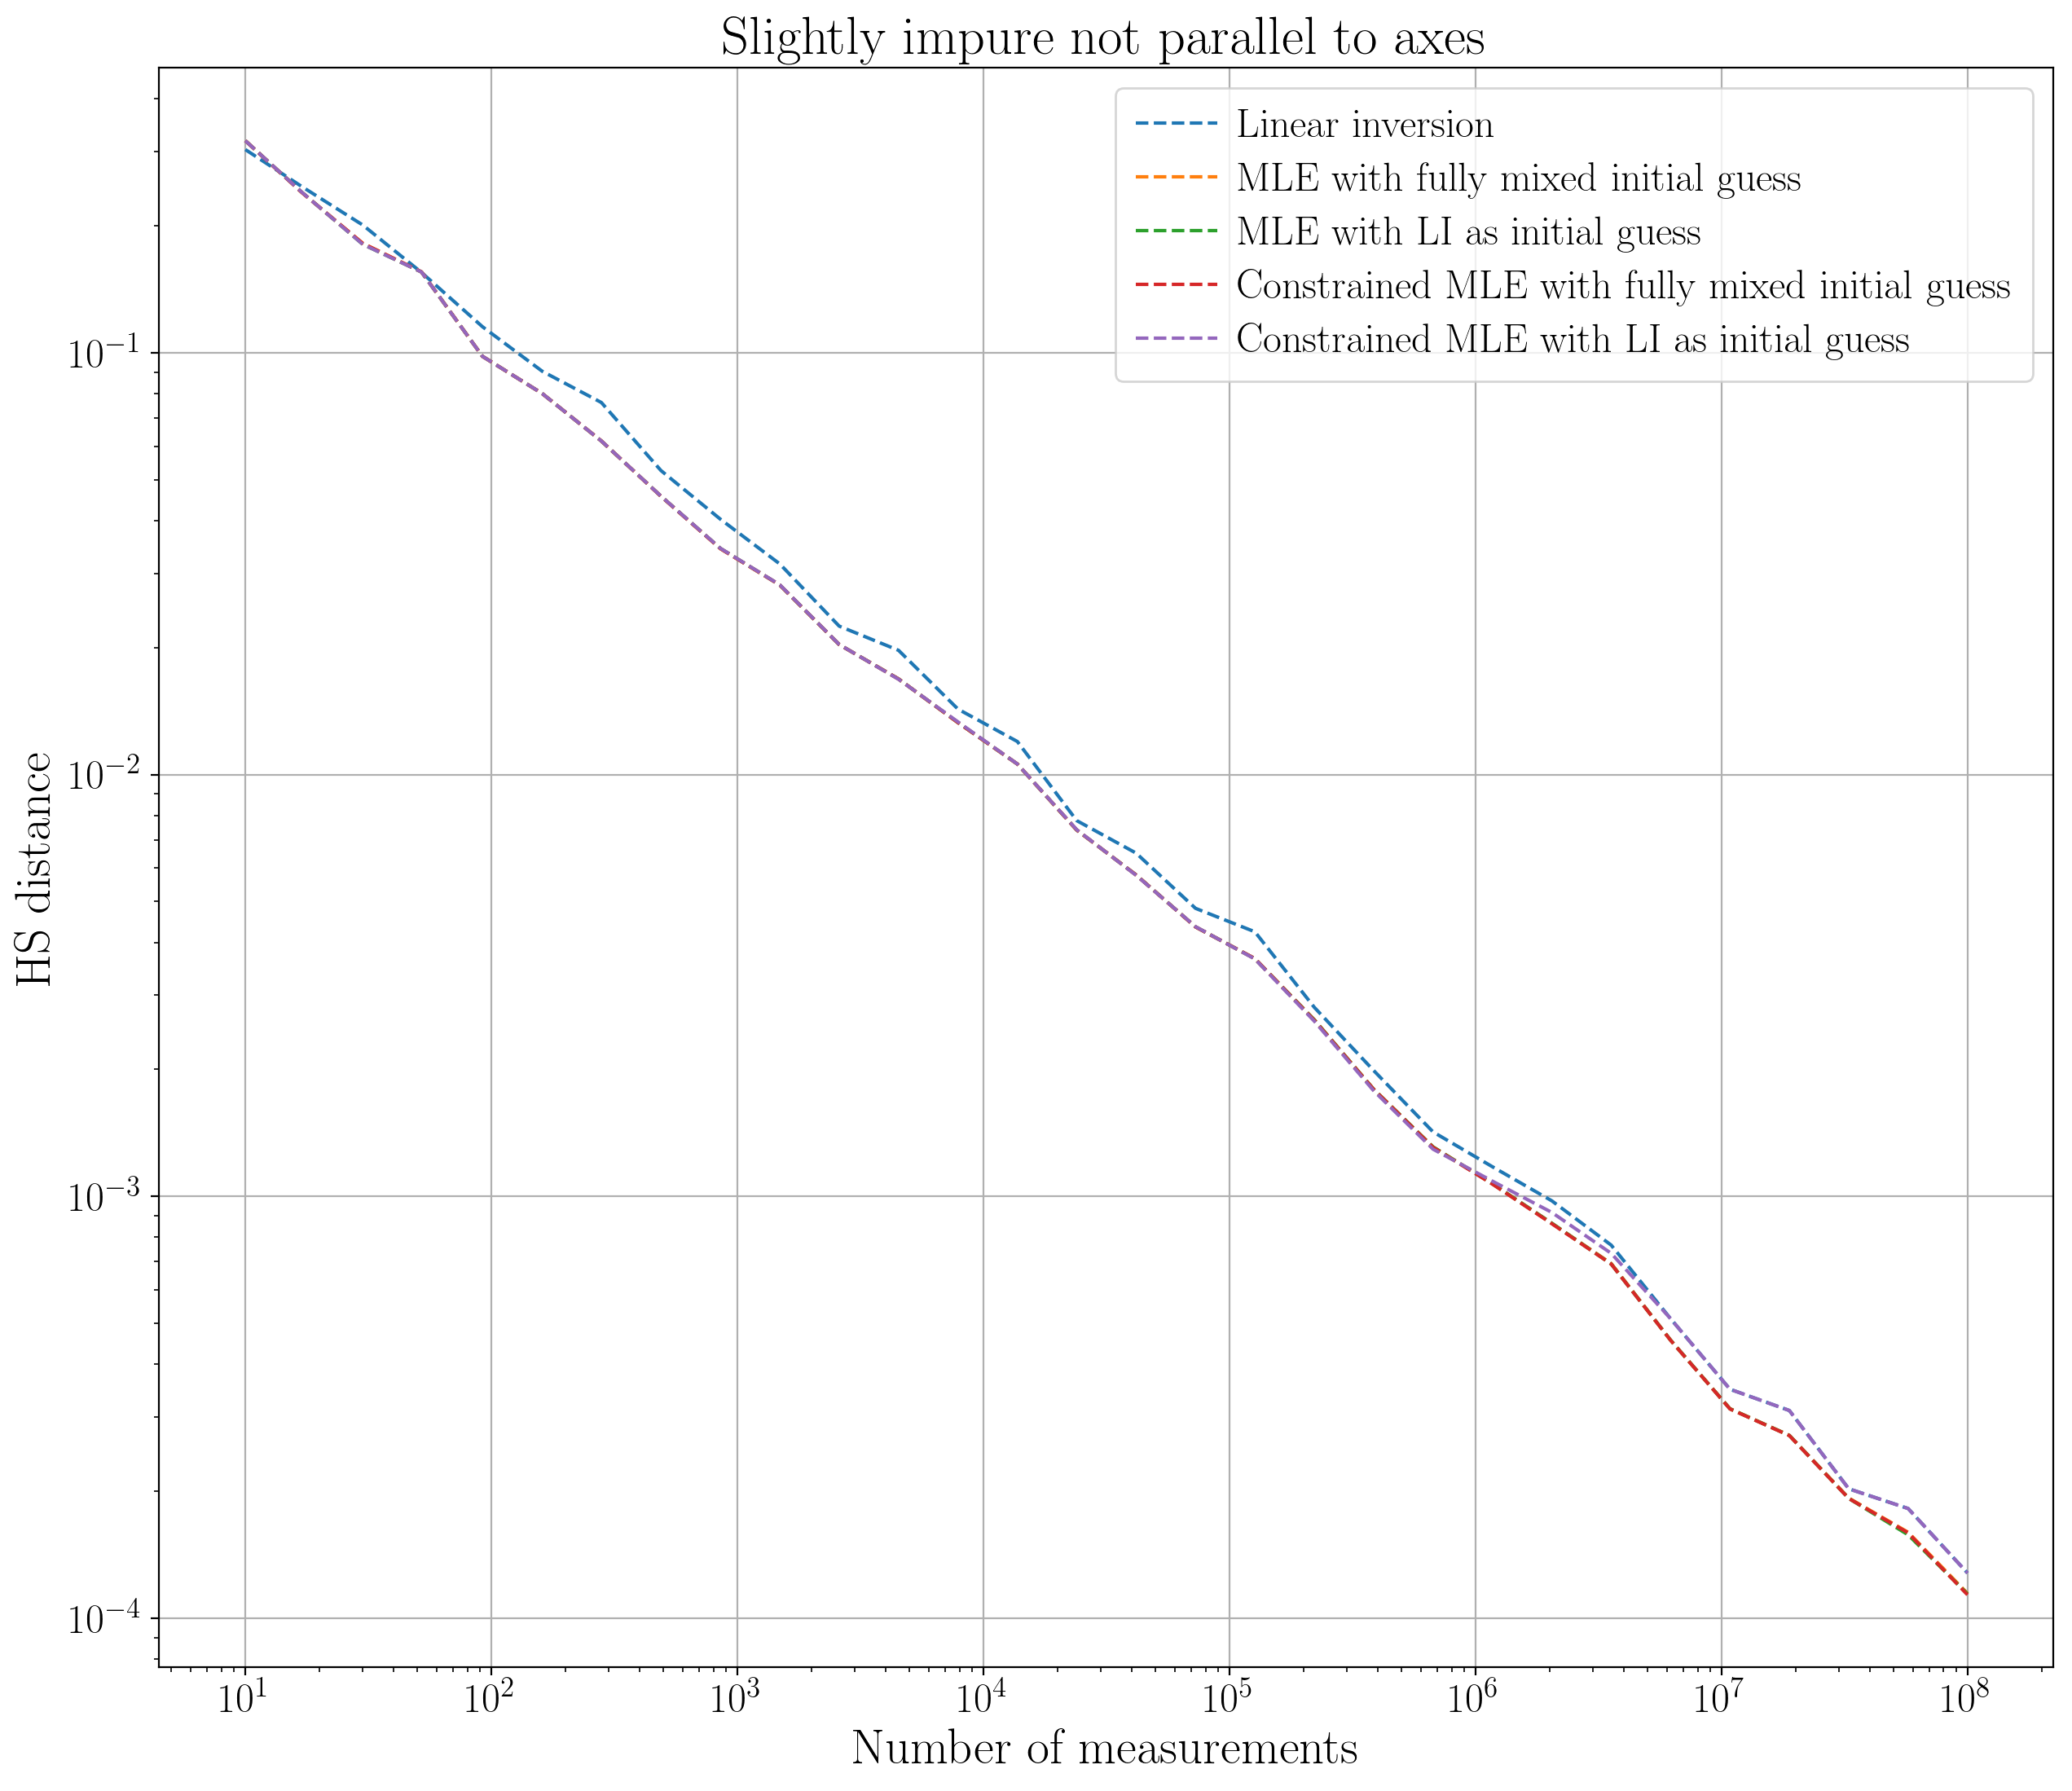

In [45]:
rho = qp.Qobj([0.5, np.sqrt(1/12) - 0.01, np.sqrt(1/12) - 0.01, np.sqrt(1/12) - 0.01])
test_quality(rho, 'Slightly impure not parallel to axes')

## Time test

In [29]:
rho_1 = qp.Qobj([0.5, 0, 0, 0.5])
rho_1

Quantum object
array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

### Linear inversion

In [31]:
max_dim = 6
rho = rho_1.copy()
lin_times = []

for dim in range(max_dim):
    tmg = qp.StateTomograph(rho)
    tmg.experiment(10000)
    n_repeats = 10 ** (max_dim - dim - 1)
    start = time.time()
    for _ in range(n_repeats):
        a = tmg.point_estimate('lin')
    end = time.time()
    lin_times.append((end - start) / n_repeats)
    rho = rho.kron(rho_1)

### MLE

In [37]:
max_dim = 4
rho = rho_1.copy()
mle_lin_init_times = []
mle_mixed_init_times = []
mle_constr_lin_init_times = []
mle_constr_mixed_init_times = []

for _ in range(max_dim):
    tmg = qp.StateTomograph(rho)
    tmg.experiment(10000)
    
    start = time.time()
    a = tmg.point_estimate('mle', init='lin')
    end = time.time()
    mle_lin_init_times.append(end - start)
    
    start = time.time()
    a = tmg.point_estimate('mle', init='mixed')
    end = time.time()
    mle_mixed_init_times.append(end - start)
    
    start = time.time()
    a = tmg.point_estimate('mle-constr', init='lin')
    end = time.time()
    mle_constr_lin_init_times.append(end - start)
    
    start = time.time()
    a = tmg.point_estimate('mle-constr', init='mixed')
    end = time.time()
    mle_constr_mixed_init_times.append(end - start)
    
    rho = rho.kron(rho_1)

### Plot

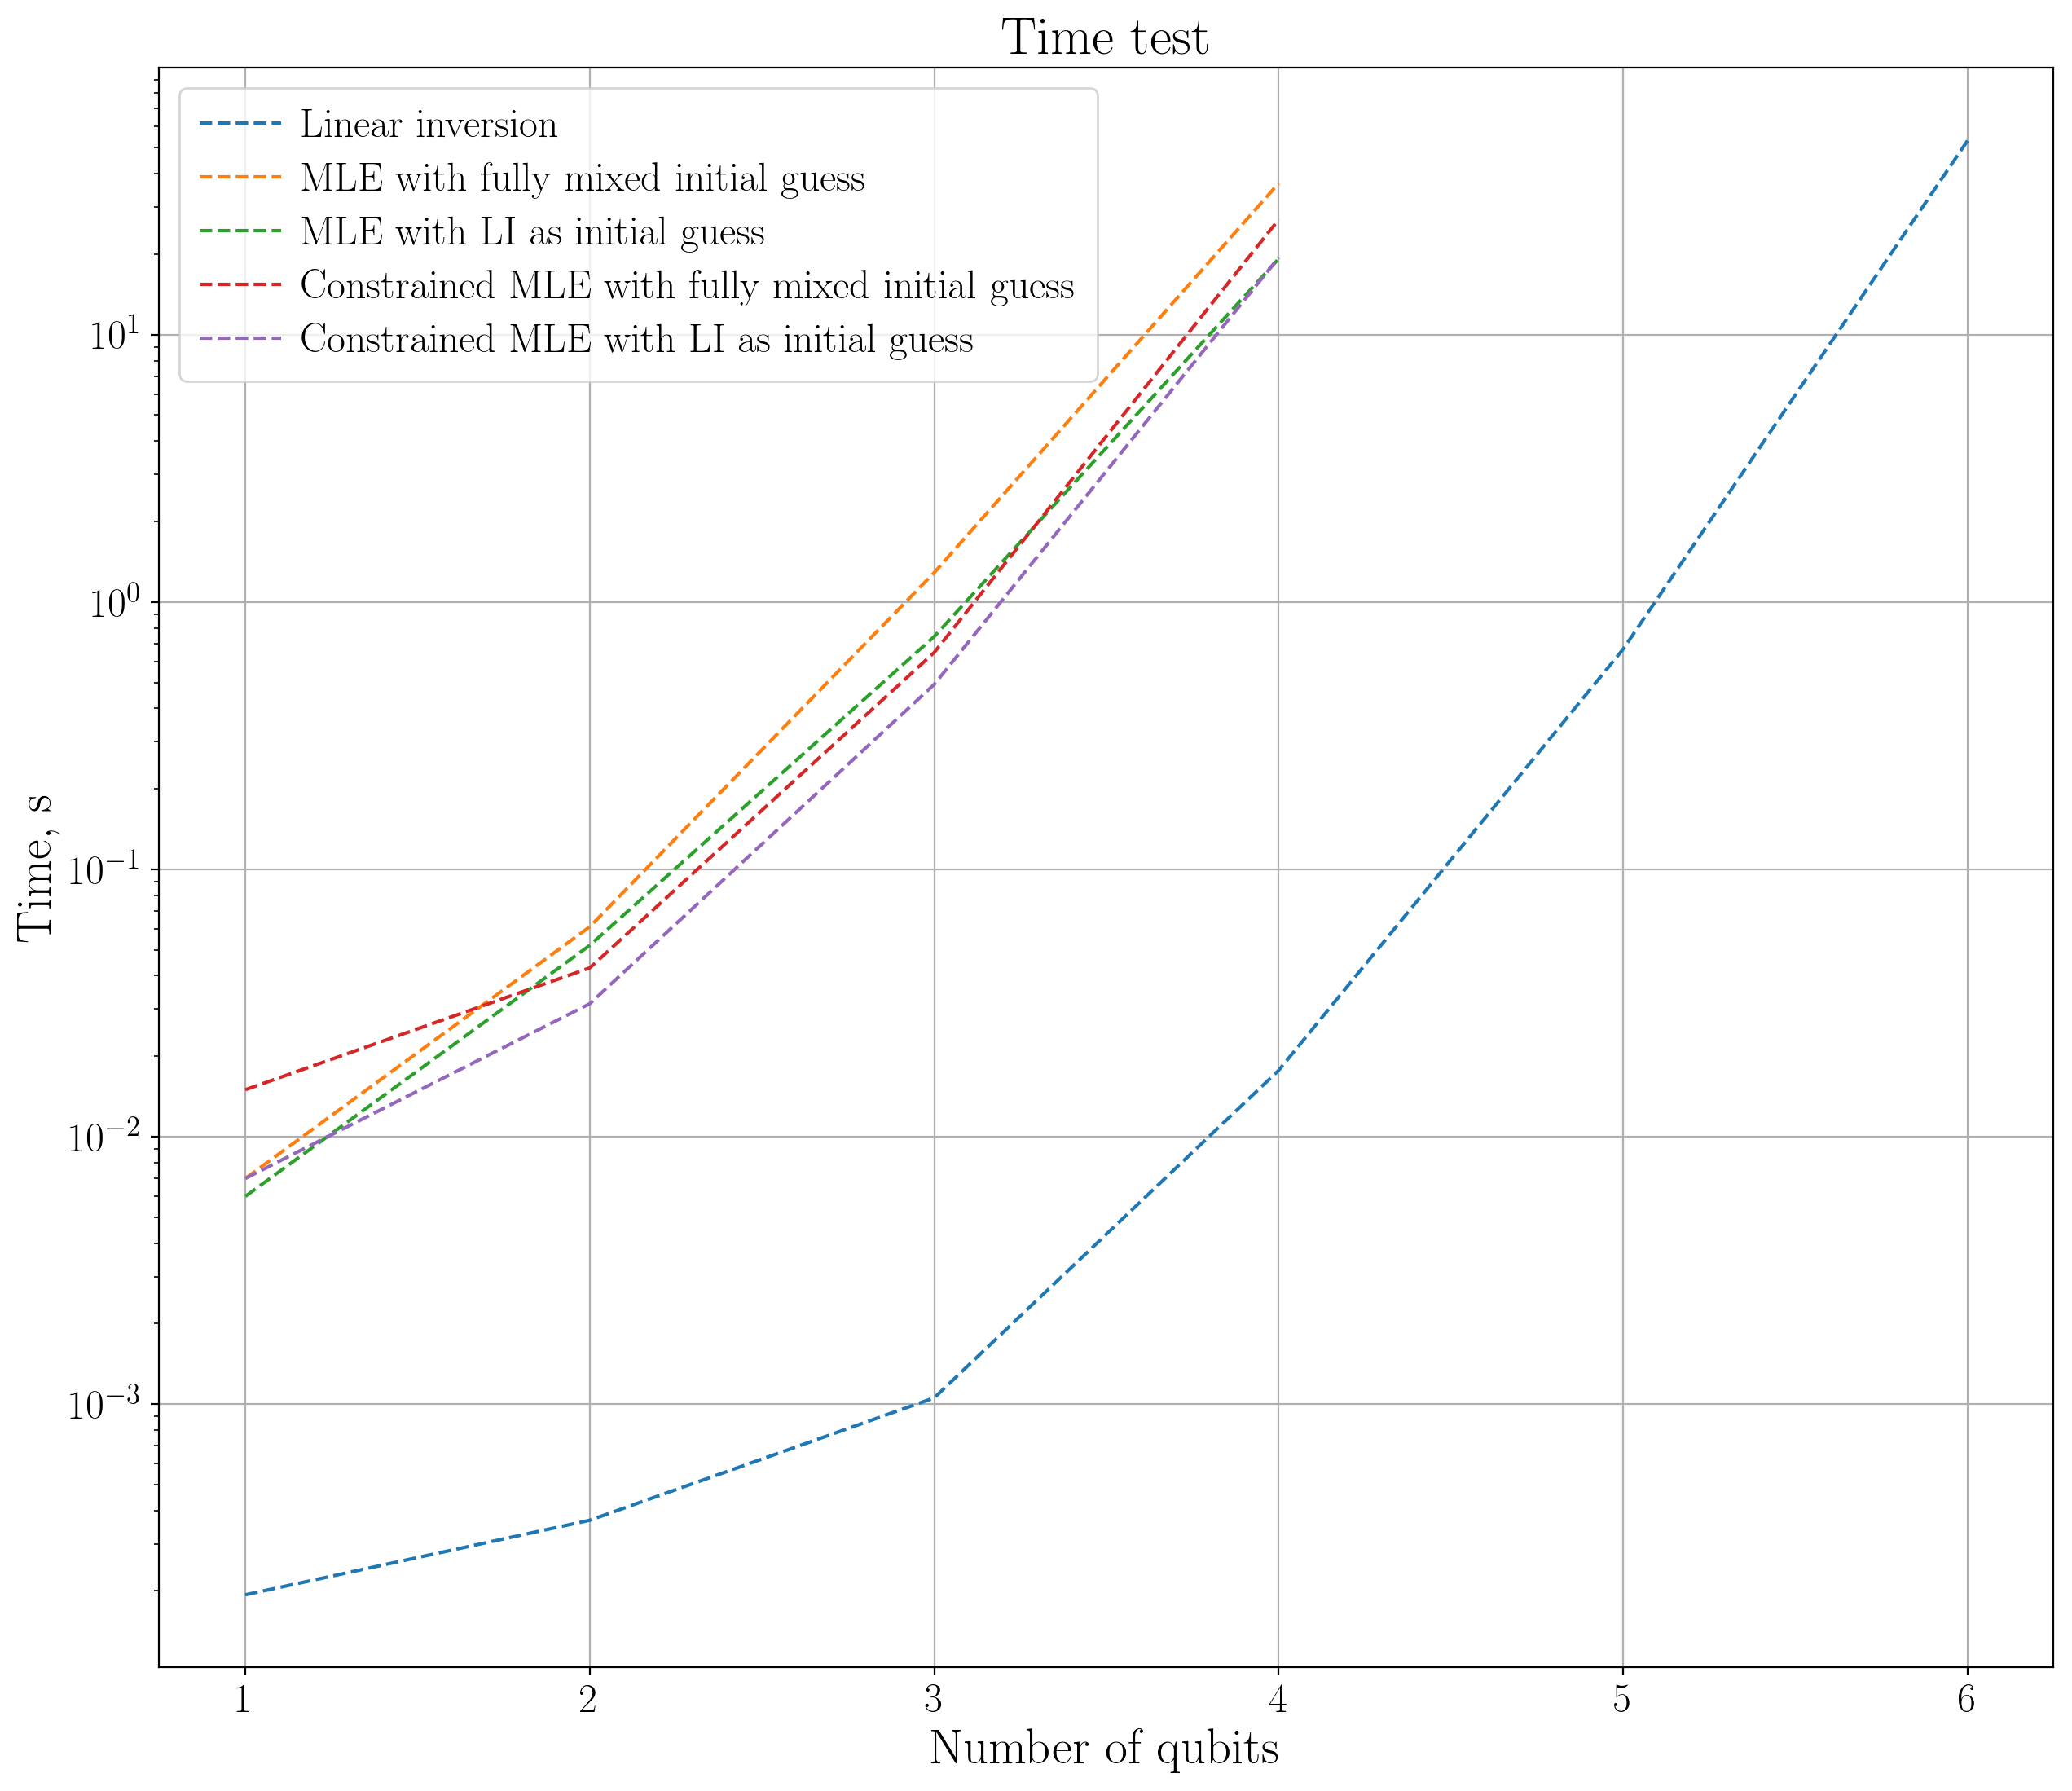

In [39]:
plt.figure(figsize=(15, 13), dpi=200)
plt.grid()
plt.xlabel('Number of qubits')
plt.ylabel('Time, s')
plt.yscale('log')
plt.plot(np.arange(1, 7), lin_times, '--', label='Linear inversion')
plt.plot(np.arange(1, 5), mle_mixed_init_times, '--', label='MLE with fully mixed initial guess')
plt.plot(np.arange(1, 5), mle_lin_init_times, '--', label='MLE with LI as initial guess')
plt.plot(np.arange(1, 5), mle_constr_mixed_init_times, '--', label='Constrained MLE with fully mixed initial guess')
plt.plot(np.arange(1, 5), mle_constr_lin_init_times, '--', label='Constrained MLE with LI as initial guess')
plt.legend()
plt.title('Time test')
plt.savefig('pictures/time_test.png', dpi=200)
plt.show()